In [1]:
from util.sound_processing import *
import numpy as np
import json
from matplotlib import pyplot as plt
import os
from scipy.interpolate import interp1d
from util.sound_processing import *
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
from sklearn.preprocessing import OneHotEncoder
import sklearn as sk
from util.sound_processing import *
VOWELS = set(['AA', 'AE', 'AH', 'AO', 'AW', 'AY', 'EH', 'EY', 'IH', 'IY', 'OW', 'OY', 'UH', 'UW', "ER", "N"])

In [2]:
def get_subarrays_indexes_from_time_interval(intervals, xs):
    # here i'm assuming that all interval in intervals have [t0, t1] where t0 < t1
    x_vals_low = [-1, -1]
    index_intervals = []


    # iterate through the intervals
    search_pointer = 0
    for interval in intervals:
        # find the start of the interval
        index_interval = [-1, -1]
        for i in range(search_pointer, xs.shape[0]):
            if xs[i] >= interval[0]:
                index_interval[0] = i
                search_pointer = i
                break
        if interval[0] == interval[1]:
            index_interval[1] = search_pointer
        else:
            for i in range(search_pointer, xs.shape[0]):
                if xs[i] >= interval[1]:
                    index_interval[1] = max(i - 1, 0)
                    search_pointer = max(i - 1, 0)
                    break
        index_intervals.append(index_interval)
    return index_intervals
def get_lip_shapes(mp_arr):
    upper_lip_bottom = 13
    lower_lip_top = 14
    # lower_lip_bottom = 17
    left_lip = 292
    right_lip = 62

    lip_parameters = [upper_lip_bottom, lower_lip_top, left_lip, right_lip]
    vertical_openning = np.linalg.norm(mp_arr[:,lip_parameters[0]] - mp_arr[:,lip_parameters[1]], axis=1)
    vertical_openning = (vertical_openning - vertical_openning.min())/(vertical_openning.max() - vertical_openning.min())
    horizontal_openning = np.linalg.norm(mp_arr[:,lip_parameters[2]] - mp_arr[:,lip_parameters[3]], axis=1)
    horizontal_openning = (horizontal_openning - horizontal_openning.min())/(horizontal_openning.max() - horizontal_openning.min())
    return [vertical_openning, horizontal_openning]

### Lip + Jaw Shape study, Video 12

In [3]:
dir = "E:\\MASC\\facial_data_analysis_videos\\12\\audio_data"
file_name_template = "video_vocals"
lyric = combine_lyric_alignment_textgrids(dir, file_name_template)

In [4]:
print(lyric.xs)

[2.40000e-02 3.40000e-02 4.40000e-02 ... 1.63284e+02 1.63294e+02
 1.63304e+02]


In [27]:
landmark_data_path = "E:\\MASC\\facial_data_analysis_videos\\12\\video\\raw_mediapipe_landmark.npy"
landmark_data = np.load(landmark_data_path)
landmark_data_xs = np.arange(0, landmark_data.shape[0])
landmark_data_xs = landmark_data_xs/30
vertical, horizontal = get_lip_shapes(landmark_data)

vowel_intervals = []
vowel_lists = []
for i in range(0, len(lyric.phoneme_list)):
    if lyric.phoneme_list[i] in VOWELS:
        vowel_intervals.append(lyric.phoneme_intervals[i])
        vowel_lists.append(lyric.phoneme_list[i])
interval_indexes_visual = get_subarrays_indexes_from_time_interval(vowel_intervals, landmark_data_xs)
interval_indexes_pitch = get_subarrays_indexes_from_time_interval(vowel_intervals, lyric.pitch.xs())
interval_indexes_intensity = get_subarrays_indexes_from_time_interval(vowel_intervals, lyric.intensity.xs())

horizontal_interp = interp1d(landmark_data_xs, horizontal, kind="linear")
vertical_interp = interp1d(landmark_data_xs, vertical, kind="linear")
normed_pitch = (lyric.pitch_arr - lyric.pitch_arr.mean())/lyric.pitch_arr.std()
normed_pitch = lyric.pitch_arr
pitch_interp = interp1d(lyric.pitch.xs(), normed_pitch, kind="linear")
normed_intensity = (lyric.intensity_arr[:,0] - lyric.intensity_arr[:,0].mean())/lyric.intensity_arr[:,0].std()
intensity_interp = interp1d(lyric.intensity.xs(), normed_intensity, kind="linear")

In [28]:
vertical_data_target = []
data = []

for i in range(0, len(vowel_lists)):
    x_i = np.arange(vowel_intervals[i][0], vowel_intervals[i][1], 0.01)
    vertical_data_target.append(horizontal_interp(x_i))
    data_i = np.zeros((pitch_interp(x_i).shape[0], 2))
    data_i[:, 0] = pitch_interp(x_i)
    data_i[:, 1] = intensity_interp(x_i)
    data.append(data_i)
data = np.concatenate(data, axis = 0)
vertical_data_target = np.concatenate(vertical_data_target, axis = 0)

In [29]:
data = data[:,0]
# data = (data - data.mean())/data.std()
# vertical_data_target = (vertical_data_target - vertical_data_target.mean())/vertical_data_target.std()

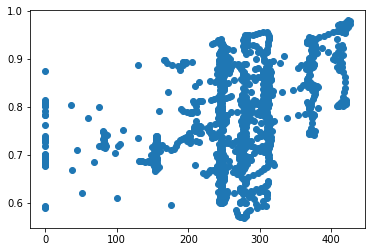

In [30]:
plt.plot(data, vertical_data_target, 'o')

train acc: 0.007951588295002681
test acc: 0.007202462971069106


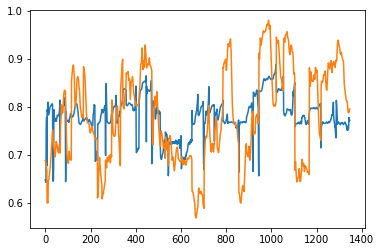

In [79]:
X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(data, vertical_data_target, test_size=0.10)
reg = sk.linear_model.LinearRegression().fit(X_train, y_train)
pred_y = reg.predict(X_train)
print("train acc:", np.square(pred_y - y_train).mean())
pred_y = reg.predict(X_test)
print("test acc:", np.square(pred_y - y_test).mean())
plt.plot(reg.predict(data))
plt.plot(vertical_data_target)


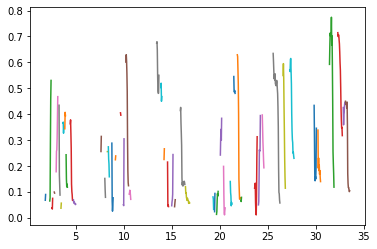

In [78]:
for i in range(0, len(vowel_lists)):
    plt.plot(landmark_data_xs[interval_indexes_visual[i][0]:interval_indexes_visual[i][1]], 
             vertical[interval_indexes_visual[i][0]:interval_indexes_visual[i][1]], label="vertical")


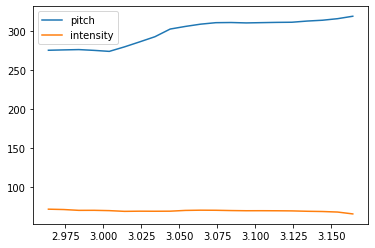

In [44]:
plt.plot(lyric.pitch.xs()[interval_indexes_pitch[i][0]:interval_indexes_pitch[i][1]], 
         lyric.pitch_arr[interval_indexes_pitch[i][0]:interval_indexes_pitch[i][1]], label="pitch")
plt.plot(lyric.intensity.xs()[interval_indexes_intensity[i][0]:interval_indexes_intensity[i][1]], 
         lyric.intensity_arr[:,0][interval_indexes_intensity[i][0]:interval_indexes_intensity[i][1]], label="intensity")
plt.legend()